In [1]:
import numpy as np
import qrcode
import pickle

from enum import Enum, auto

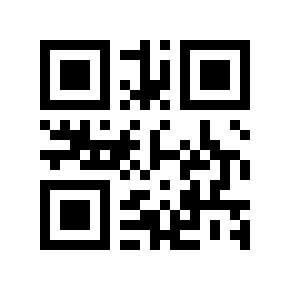

In [2]:
qr = qrcode.QRCode(error_correction=qrcode.ERROR_CORRECT_M)
qr.add_data("HELLO WORLD")
qr.make_image()
# qr.add_data("9"*20)
# qr.best_fit()

In [2]:
# class ModeIndicator(Enum):
#     numeric_mode = 0b0001
#     alphanumeric_mode = 0b0010
#     byte_mode = 0b0100
#     kanji_mode = 0b1000
#     ECI_mode = 0b0111

# mode_indicator_mapping = {0b0001:0, 0b0010: 1, 0b0100:2, 0b1000:3}

class ModeIndicator(Enum):
    numeric_mode = 0
    alphanumeric_mode = auto()
    byte_mode = auto()
    kanji_mode = auto()
    ECI_mode = auto()

mode_indicator_mapping = {
    ModeIndicator.numeric_mode: "0001", 
    ModeIndicator.alphanumeric_mode: "0010", 
    ModeIndicator.byte_mode: "0100", 
    ModeIndicator.kanji_mode: "1000"
}

class ErrorCorrectionLevel(Enum):
    L = 1
    M = 2
    Q = 3
    H = 4

class SizeLevel(Enum):
    small = auto()
    medium = auto()
    large = auto()

assert mode_indicator_mapping[ModeIndicator.numeric_mode] == "0001"
assert mode_indicator_mapping[ModeIndicator.alphanumeric_mode] == "0010"
assert mode_indicator_mapping[ModeIndicator.byte_mode] == "0100"
assert mode_indicator_mapping[ModeIndicator.kanji_mode] == "1000"

In [3]:
# size_level
#   Small: 1 to 9
#   Medium: 10 to 26
#   Large: 27 to 40

def get_size_from_version(version: int) -> str:
    if not 0 < version < 41:
        raise ValueError(f"the specified version is not between 1 through 40 (inclusive): {version}")
    if 1 <= version <= 9:
        return SizeLevel.small
    if 10 <= version <= 26:
        return SizeLevel.medium
    if 27 <= version <= 40:
        return SizeLevel.large

assert get_size_from_version(5) == SizeLevel.small
assert get_size_from_version(9) == SizeLevel.small
assert get_size_from_version(26) == SizeLevel.medium
assert get_size_from_version(40) == SizeLevel.large

In [35]:
char_count_byte_length_for_version_and_mode = {
    SizeLevel.small : {
        ModeIndicator.numeric_mode : 10,
        ModeIndicator.alphanumeric_mode : 9,
        ModeIndicator.byte_mode : 8,
        ModeIndicator.kanji_mode : 8
    },
    SizeLevel.medium : {
        ModeIndicator.numeric_mode : 12,
        ModeIndicator.alphanumeric_mode : 11,
        ModeIndicator.byte_mode : 16,
        ModeIndicator.kanji_mode : 10
    },
    SizeLevel.large : {
        ModeIndicator.numeric_mode : 14,
        ModeIndicator.alphanumeric_mode : 13,
        ModeIndicator.byte_mode : 16,
        ModeIndicator.kanji_mode : 12
    }
}

def get_char_counter_pad(version: int, mode: ModeIndicator):
    return char_count_byte_length_for_version_and_mode[get_size_from_version(version)][mode]

assert get_char_counter_pad(1, ModeIndicator.alphanumeric_mode) == 9
assert get_char_counter_pad(20, ModeIndicator.byte_mode) == 16

def get_char_counter_binary(length: int, version: int, mode: ModeIndicator):
    pad = get_char_counter_pad(version, mode) # get the amount of padding needed
    return format(length, f">0{pad}b")  # pad the binary to the length specified

assert get_char_counter_binary(11, 1, ModeIndicator.alphanumeric_mode) == '000001011'
assert get_char_counter_binary(100, 30, ModeIndicator.alphanumeric_mode) == '0000001100100'

In [36]:
filepath = "../resources/version.pickle"

with open(filepath, "rb") as file:
    versions = pickle.load(file)

In [37]:
def get_minimum_version(character_length, mode, error_correction_level, minimum_version=1):
    """ get the minumum version (equivalent to the size of the qr code) for the specified mode and error correction level
    """
    for index, version in enumerate(versions):
        len_in_version = version[error_correction_level.value][mode.value]
        if len_in_version >= character_length:
            return max(index+1, minimum_version)

        #     if index+1 < minimum_version:
        #         return minimum_version
        #     return index+1
    raise Exception("data too big")

assert get_minimum_version(20, ModeIndicator.alphanumeric_mode, ErrorCorrectionLevel.M, minimum_version=10) == 10
assert get_minimum_version(2000, ModeIndicator.alphanumeric_mode, ErrorCorrectionLevel.L) == 27
assert get_minimum_version(2000, ModeIndicator.numeric_mode, ErrorCorrectionLevel.Q, minimum_version=26) == 28
assert get_minimum_version(2000, ModeIndicator.byte_mode, ErrorCorrectionLevel.L) == 33

In [38]:
digits = "0123456789" # only digits
alphanumeric = "0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ $%*+-./:" # digits, cap_alphabet, space, $, %, *, +, -, ., /, :

def get_val_for_char(char):
    return alphanumeric.find(char)

assert get_val_for_char('A') == 10
assert get_val_for_char(':') == 44

def get_char_for_val(val):
    return alphanumeric[val]

assert get_char_for_val(10) == 'A'
assert get_char_for_val(44) == ':'

In [39]:
def get_mode(data):
    if set(data).issubset(digits): # or use re.match
        return ModeIndicator.numeric_mode
    elif set(data).issubset(alphanumeric):
        return ModeIndicator.alphanumeric_mode
    # elif # kanji
    #     print("use kanji mode")
        # mode_indicator = ModeIndicator.kanji_mode
    else:
        return ModeIndicator.byte_mode

assert get_mode("12434") == ModeIndicator.numeric_mode
assert get_mode("HELLO WORLD*+-123") == ModeIndicator.alphanumeric_mode
assert get_mode("324kjdsfSFJ!") == ModeIndicator.byte_mode

# not implemented:
#   - Extended Channel Interpretation (ECI) mode
#   - Structured Append mode
#   - FNC1 mode

In [40]:
# https://www.thonky.com/qr-code-tutorial/alphanumeric-mode-encoding
def encode_alphanumeric(data):
    encoded_data = ""
    pairs = [data[i:i+2] for i in range(0, len(data), 2)]
    
    for pair in pairs:
        if len(pair) == 1:
            val = get_val_for_char(pair)
            encoded_data += format(val, ">06b")
            break
        
        val1 = get_val_for_char(pair[0])
        val2 = get_val_for_char(pair[1])
        pair_val = (45*val1)+val2

        encoded_data += format(pair_val, ">011b")
    return encoded_data

assert encode_alphanumeric("HELLO WORLD") == '0110000101101111000110100010111001011011100010011010100001101'


# https://www.thonky.com/qr-code-tutorial/numeric-mode-encoding
def encode_numeric(data):
    encoded_data = ""
    pairs = [data[i:i+3] for i in range(0, len(data), 3)]

    for pair in pairs:
        if len(pair) == 1 or pair[0:2] == "00":
            encoded_data += format(int(pair), ">04b")
        elif len(pair) == 2 or pair[0] == "0":
            encoded_data += format(int(pair), ">07b")
        elif len(pair) == 3:
            encoded_data += format(int(pair), ">010b")
    return encoded_data

assert encode_numeric("8675309") == '110110001110000100101001'


# https://www.thonky.com/qr-code-tutorial/byte-mode-encoding
def encode_byte(data):
    data_bytes = data.encode("ISO 8859-1") # iso 8859 latin-1 (Western europe)
    # data_bytes = data.encode("UTF-8")

    encoded_data = "".join(format(byte, "0>8b") for byte in data_bytes)
    return encoded_data

assert encode_byte("Hello, world!") == '01001000011001010110110001101100011011110010110000100000011101110110111101110010011011000110010000100001'


# https://www.thonky.com/qr-code-tutorial/kanji-mode-encoding
def encode_kanji(data):
    pass

In [41]:
def encode_data(data, mode):
    if mode == ModeIndicator.numeric_mode:
        return encode_numeric(data)
    elif mode == ModeIndicator.alphanumeric_mode:
        return encode_alphanumeric(data)
    elif mode == ModeIndicator.byte_mode:
        return encode_byte(data)
    elif mode == ModeIndicator.kanji_mode:
        return encode_kanji(data)


In [42]:
# data = "this is some data to be encoded into an QR-Code"
# data = "1343a"
data = "HELLO WORLD"

error_correction_level = ErrorCorrectionLevel.M
mode_indicator = ModeIndicator.alphanumeric_mode
supposed_size_for_version_and_mode = 11 # optional

In [43]:
import codecs
codecs.decode(b"Zm9vOnBhc3N3b3Jk")

'Zm9vOnBhc3N3b3Jk'

In [44]:
data = "HELLO WORLD"
error_correction_level = ErrorCorrectionLevel.L
mode = get_mode(data)
version = get_minimum_version(len(data), mode, error_correction_level)

mode_indicator = mode_indicator_mapping[mode]
character_count_indicator = get_char_counter_binary(len(data), version, mode)
encoded_data = encode_data(data, mode)

total = mode_indicator + "|" + character_count_indicator
# total = mode_indicator

print(f"{data=}, {len(data)=}, {error_correction_level.name=}, {mode.name=}, {version=}")
print(f"{mode_indicator=}, {character_count_indicator=}")
print(f"{total=}")

data='HELLO WORLD', len(data)=11, error_correction_level.name='L', mode.name='alphanumeric_mode', version=1
mode_indicator='0010', character_count_indicator='000001011'
total='0010|000001011'
